In [3]:
import os
import matplotlib.pyplot as plt
%matplotlib inline

In [73]:
import torch
import sys
import os
import torch
import numpy
import importlib
import torch.nn.functional as F
from scipy.io import wavfile
from collections import defaultdict

from sklearn import manifold

In [14]:
os.environ['CUDA_VISIBLE_DEVICES'] = '5'

In [8]:
sys.path.append('/workspace/GREAT_ASV_system/train_dist')
sys.path.append('/workspace/GREAT_ASV_system/DA-exp')

In [19]:
SpeakerNetModel = importlib.import_module('models.'+'EPACA-TDNNL').__getattribute__('MainModel')

In [21]:
# EPACA-TDNN
S = SpeakerNetModel(n_mels=40, nOut=192, spec_aug=False)

EPACA-TDNNL.py, Embedding size is 192, Channels 512, Spec_aug False.


In [22]:
model_path = '/workspace/LOGS_OUTPUT/tmp_logs/train_logs_201120/epaca_tdnnl_aldatest_beta0/model/model000000120.model'

In [23]:
S.cuda()

ECAPA_TDNN(
  (instancenorm): InstanceNorm1d(40, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
  (torchfb): Sequential(
    (0): PreEmphasis()
    (1): MelSpectrogram(
      (spectrogram): Spectrogram()
      (mel_scale): MelScale()
    )
  )
  (layer1): Conv1dReluBn(
    (conv): Conv1d(40, 512, kernel_size=(5,), stride=(1,), padding=(2,), bias=False)
    (bn): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): Sequential(
    (0): Conv1dReluBn(
      (conv): Conv1d(512, 512, kernel_size=(1,), stride=(1,), bias=False)
      (bn): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): Res2Conv1dReluBn(
      (convs): ModuleList(
        (0): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(2,), dilation=(2,), bias=False)
        (1): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(2,), dilation=(2,), bias=False)
        (2): Conv1d(64, 64, kernel_size=(3,), stride=(1,)

In [24]:
loaded_state = torch.load(model_path, map_location="cuda:0")

In [25]:
self_state = S.state_dict()

for name, param in loaded_state['model'].items():
    origname = name
    if name not in self_state:
        name = name.replace("__S__.", "")

        if name not in self_state:
            print("#%s is not in the model."%origname)
            continue

    if self_state[name].size() != loaded_state['model'][origname].size():
        print("#Wrong parameter length: %s, model: %s, loaded: %s"%(origname, self_state[name].size(), loaded_state[origname].size()))
        continue

    self_state[name].copy_(param)

#__L__.W is not in the model.
#DA_module.backbone.torchfb.0.flipped_filter is not in the model.
#DA_module.backbone.torchfb.1.spectrogram.window is not in the model.
#DA_module.backbone.torchfb.1.mel_scale.fb is not in the model.
#DA_module.backbone.layer1.conv.weight is not in the model.
#DA_module.backbone.layer1.bn.weight is not in the model.
#DA_module.backbone.layer1.bn.bias is not in the model.
#DA_module.backbone.layer1.bn.running_mean is not in the model.
#DA_module.backbone.layer1.bn.running_var is not in the model.
#DA_module.backbone.layer1.bn.num_batches_tracked is not in the model.
#DA_module.backbone.layer2.0.conv.weight is not in the model.
#DA_module.backbone.layer2.0.bn.weight is not in the model.
#DA_module.backbone.layer2.0.bn.bias is not in the model.
#DA_module.backbone.layer2.0.bn.running_mean is not in the model.
#DA_module.backbone.layer2.0.bn.running_var is not in the model.
#DA_module.backbone.layer2.0.bn.num_batches_tracked is not in the model.
#DA_module.bac

In [28]:
S.eval()

ECAPA_TDNN(
  (instancenorm): InstanceNorm1d(40, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
  (torchfb): Sequential(
    (0): PreEmphasis()
    (1): MelSpectrogram(
      (spectrogram): Spectrogram()
      (mel_scale): MelScale()
    )
  )
  (layer1): Conv1dReluBn(
    (conv): Conv1d(40, 512, kernel_size=(5,), stride=(1,), padding=(2,), bias=False)
    (bn): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): Sequential(
    (0): Conv1dReluBn(
      (conv): Conv1d(512, 512, kernel_size=(1,), stride=(1,), bias=False)
      (bn): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): Res2Conv1dReluBn(
      (convs): ModuleList(
        (0): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(2,), dilation=(2,), bias=False)
        (1): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(2,), dilation=(2,), bias=False)
        (2): Conv1d(64, 64, kernel_size=(3,), stride=(1,)

In [29]:
def loadWAV(filename):

    # Maximum audio length
    
    max_audio = int(0*16000 + 240)

    # Read wav file and convert to torch tensor
    sample_rate, audio  = wavfile.read(filename)
    
    audiosize = audio.shape[0]

    if audiosize <= max_audio:
        shortage    = max_audio - audiosize + 1 
        audio       = numpy.pad(audio, (0, shortage), 'wrap')
        audiosize   = audio.shape[0]
    
    feats = []

    feats.append(audio)

    feat = numpy.stack(feats,axis=0).astype(numpy.float)

    return feat

In [39]:
train_list_1 = '/workspace/DATASET/server9_ssd/voxceleb/vox2_trainlist.txt'
train_path_1 = '/workspace/DATASET/server9_ssd/voxceleb'
train_list_2 = '/workspace/DATASET/server9_ssd/sdsv20/sdsv20_trainlist.txt'
train_path_2 = '/workspace/DATASET/server9_ssd/sdsv20'

In [31]:
with open(train_list_1, 'r') as f:
    train_list_1_list = f.readlines()

In [32]:
len(train_list_1_list)

1092009

In [38]:
emb_list = {}
for count, line in enumerate(train_list_1_list):
    label, wavline = line[:-1].split(' ')
    wavline = os.path.join(train_path_1, wavline)
    raw_inp = loadWAV(wavline)
    raw_inp = torch.FloatTensor(raw_inp).cuda()
    
    ref_feat = S.forward(raw_inp).detach().cpu().numpy()
    
    if label not in emb_list.keys():
        if len(emb_list) > 100:
            print('collect 100 classes')
            print('count: ', count)
            break
        emb_list[label] = ref_feat
    else:
        emb_list[label] = numpy.append(emb_list[label], ref_feat, axis=0)
    
    if ((count+1) % 1000) == 0:
        print((count+1)//1000, end='\r')

collect 100 classes
count:  18395


In [40]:
with open(train_list_2, 'r') as f:
    train_list_2_list = f.readlines()

In [41]:
len(train_list_2_list)

85764

In [42]:
emb_list_2 = {}
for count, line in enumerate(train_list_2_list):
    label, wavline = line[:-1].split(' ')
    wavline = os.path.join(train_path_2, wavline)
    raw_inp = loadWAV(wavline)
    raw_inp = torch.FloatTensor(raw_inp).cuda()
    
    ref_feat = S.forward(raw_inp).detach().cpu().numpy()
    
    if label not in emb_list_2.keys():
        if len(emb_list_2) > 100:
            print('collect 100 classes')
            print('count: ', count)
            break
        emb_list_2[label] = ref_feat
    else:
        emb_list_2[label] = numpy.append(emb_list_2[label], ref_feat, axis=0)
    
    
#     if label not in cohort_spk_dict.keys():
#         cohort_spk_dict[label] = ref_feat
#     else:
#         cohort_spk_dict[label] = torch.cat([cohort_spk_dict[label], ref_feat], dim=0)
    if ((count+1) % 1000) == 0:
        print((count+1)//1000, end='\r')

collect 100 classes
count:  16099


In [52]:
emb_list['id00012'].shape

(164, 192)

In [65]:
out_list = numpy.zeros([0, 192])
for count, i in enumerate(emb_list):
    if count > 74:
        break
    out_list = numpy.append(out_list, emb_list[i][0:20], axis=0)

In [66]:
out_list.shape

(1500, 192)

In [68]:
out_list_2 = numpy.zeros([0, 192])
for count, i in enumerate(emb_list_2):
    if count > 14:
        break
    out_list_2 = numpy.append(out_list_2, emb_list_2[i][0:20], axis=0)

In [69]:
out_list_2.shape

(300, 192)

In [71]:
out_label = out_list.shape[0]*[0] +out_list_2.shape[0]*[1]
out_list_f = numpy.append(out_list, out_list_2, axis=0)

In [74]:
tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
Y = tsne.fit_transform(out_list_f)

Text(0.5, 1.0, 'Emb plot for RW-B-ALDA training')

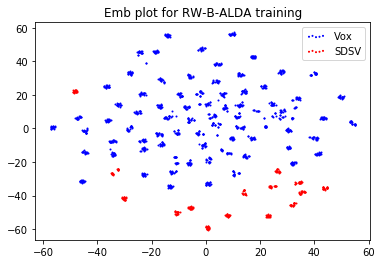

In [75]:
fig = plt.figure()
Y1 = Y[0:out_list.shape[0]]
out_label_1 = out_label[0:out_list.shape[0]]
Y2 = Y[out_list.shape[0]:out_list.shape[0]+out_list_2.shape[0]]
out_label_2 = out_label[out_list.shape[0]:out_list.shape[0]+out_list_2.shape[0]]
a = plt.scatter(Y1[:, 0], Y1[:, 1], color='b', s=1)
b = plt.scatter(Y2[:, 0], Y2[:, 1], color='r', s=1)
plt.legend([a, b],['Vox', 'SDSV'], scatterpoints=5)
plt.title('Emb plot for RW-B-ALDA training')

In [78]:
model_path = '/workspace/LOGS_OUTPUT/tmp_logs/train_logs_201120/datest2_0.01/model/model000000123.model'

In [79]:
S.cuda()

ECAPA_TDNN(
  (instancenorm): InstanceNorm1d(40, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
  (torchfb): Sequential(
    (0): PreEmphasis()
    (1): MelSpectrogram(
      (spectrogram): Spectrogram()
      (mel_scale): MelScale()
    )
  )
  (layer1): Conv1dReluBn(
    (conv): Conv1d(40, 512, kernel_size=(5,), stride=(1,), padding=(2,), bias=False)
    (bn): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): Sequential(
    (0): Conv1dReluBn(
      (conv): Conv1d(512, 512, kernel_size=(1,), stride=(1,), bias=False)
      (bn): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): Res2Conv1dReluBn(
      (convs): ModuleList(
        (0): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(2,), dilation=(2,), bias=False)
        (1): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(2,), dilation=(2,), bias=False)
        (2): Conv1d(64, 64, kernel_size=(3,), stride=(1,)

In [80]:
loaded_state = torch.load(model_path, map_location="cuda:0")

In [82]:
self_state = S.state_dict()

for name, param in loaded_state['model'].items():
    origname = name
    if name not in self_state:
        name = name.replace("__S__.", "")

        if name not in self_state:
            print("#%s is not in the model."%origname)
            continue

    if self_state[name].size() != loaded_state['model'][origname].size():
        print("#Wrong parameter length: %s, model: %s, loaded: %s"%(origname, self_state[name].size(), loaded_state[origname].size()))
        continue

    self_state[name].copy_(param)

#__L__.W is not in the model.
#DA_module.backbone.torchfb.0.flipped_filter is not in the model.
#DA_module.backbone.torchfb.1.spectrogram.window is not in the model.
#DA_module.backbone.torchfb.1.mel_scale.fb is not in the model.
#DA_module.backbone.layer1.conv.weight is not in the model.
#DA_module.backbone.layer1.bn.weight is not in the model.
#DA_module.backbone.layer1.bn.bias is not in the model.
#DA_module.backbone.layer1.bn.running_mean is not in the model.
#DA_module.backbone.layer1.bn.running_var is not in the model.
#DA_module.backbone.layer1.bn.num_batches_tracked is not in the model.
#DA_module.backbone.layer2.0.conv.weight is not in the model.
#DA_module.backbone.layer2.0.bn.weight is not in the model.
#DA_module.backbone.layer2.0.bn.bias is not in the model.
#DA_module.backbone.layer2.0.bn.running_mean is not in the model.
#DA_module.backbone.layer2.0.bn.running_var is not in the model.
#DA_module.backbone.layer2.0.bn.num_batches_tracked is not in the model.
#DA_module.bac

In [83]:
S.eval()

ECAPA_TDNN(
  (instancenorm): InstanceNorm1d(40, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
  (torchfb): Sequential(
    (0): PreEmphasis()
    (1): MelSpectrogram(
      (spectrogram): Spectrogram()
      (mel_scale): MelScale()
    )
  )
  (layer1): Conv1dReluBn(
    (conv): Conv1d(40, 512, kernel_size=(5,), stride=(1,), padding=(2,), bias=False)
    (bn): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): Sequential(
    (0): Conv1dReluBn(
      (conv): Conv1d(512, 512, kernel_size=(1,), stride=(1,), bias=False)
      (bn): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): Res2Conv1dReluBn(
      (convs): ModuleList(
        (0): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(2,), dilation=(2,), bias=False)
        (1): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(2,), dilation=(2,), bias=False)
        (2): Conv1d(64, 64, kernel_size=(3,), stride=(1,)

In [84]:
def loadWAV(filename):

    # Maximum audio length
    
    max_audio = int(0*16000 + 240)

    # Read wav file and convert to torch tensor
    sample_rate, audio  = wavfile.read(filename)
    
    audiosize = audio.shape[0]

    if audiosize <= max_audio:
        shortage    = max_audio - audiosize + 1 
        audio       = numpy.pad(audio, (0, shortage), 'wrap')
        audiosize   = audio.shape[0]
    
    feats = []

    feats.append(audio)

    feat = numpy.stack(feats,axis=0).astype(numpy.float)

    return feat

In [85]:
train_list_1 = '/workspace/DATASET/server9_ssd/voxceleb/vox2_trainlist.txt'
train_path_1 = '/workspace/DATASET/server9_ssd/voxceleb'
train_list_2 = '/workspace/DATASET/server9_ssd/sdsv20/sdsv20_trainlist.txt'
train_path_2 = '/workspace/DATASET/server9_ssd/sdsv20'

In [86]:
with open(train_list_1, 'r') as f:
    train_list_1_list = f.readlines()

In [87]:
len(train_list_1_list)

1092009

In [88]:
emb_list_da = {}
for count, line in enumerate(train_list_1_list):
    label, wavline = line[:-1].split(' ')
    wavline = os.path.join(train_path_1, wavline)
    raw_inp = loadWAV(wavline)
    raw_inp = torch.FloatTensor(raw_inp).cuda()
    
    ref_feat = S.forward(raw_inp).detach().cpu().numpy()
    
    if label not in emb_list_da.keys():
        if len(emb_list_da) > 100:
            print('collect 100 classes')
            print('count: ', count)
            break
        emb_list_da[label] = ref_feat
    else:
        emb_list_da[label] = numpy.append(emb_list_da[label], ref_feat, axis=0)
    
    if ((count+1) % 1000) == 0:
        print((count+1)//1000, end='\r')

collect 100 classes
count:  18395


In [89]:
with open(train_list_2, 'r') as f:
    train_list_2_list = f.readlines()

In [90]:
len(train_list_2_list)

85764

In [92]:
emb_list_da_2 = {}
for count, line in enumerate(train_list_2_list):
    label, wavline = line[:-1].split(' ')
    wavline = os.path.join(train_path_2, wavline)
    raw_inp = loadWAV(wavline)
    raw_inp = torch.FloatTensor(raw_inp).cuda()
    
    ref_feat = S.forward(raw_inp).detach().cpu().numpy()
    
    if label not in emb_list_da_2.keys():
        if len(emb_list_da_2) > 100:
            print('collect 100 classes')
            print('count: ', count)
            break
        emb_list_da_2[label] = ref_feat
    else:
        emb_list_da_2[label] = numpy.append(emb_list_da_2[label], ref_feat, axis=0)
    
    
#     if label not in cohort_spk_dict.keys():
#         cohort_spk_dict[label] = ref_feat
#     else:
#         cohort_spk_dict[label] = torch.cat([cohort_spk_dict[label], ref_feat], dim=0)
    if ((count+1) % 1000) == 0:
        print((count+1)//1000, end='\r')

collect 100 classes
count:  16099


In [93]:
emb_list_da['id00012'].shape

(164, 192)

In [94]:
out_list = numpy.zeros([0, 192])
for count, i in enumerate(emb_list_da):
    if count > 74:
        break
    out_list = numpy.append(out_list, emb_list_da[i][0:20], axis=0)

In [95]:
out_list.shape

(1500, 192)

In [96]:
out_list_2 = numpy.zeros([0, 192])
for count, i in enumerate(emb_list_da_2):
    if count > 14:
        break
    out_list_2 = numpy.append(out_list_2, emb_list_da_2[i][0:20], axis=0)

In [97]:
out_list_2.shape

(300, 192)

In [101]:
out_label = out_list.shape[0]*[0] +out_list_2.shape[0]*[1]
out_list_f = numpy.append(out_list, out_list_2, axis=0)

In [102]:
tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
Y = tsne.fit_transform(out_list_f)

Text(0.5, 1.0, 'Emb plot for MIX training')

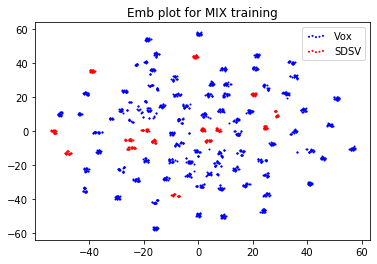

In [103]:
fig = plt.figure()
Y1 = Y[0:out_list.shape[0]]
out_label_1 = out_label[0:out_list.shape[0]]
Y2 = Y[out_list.shape[0]:out_list.shape[0]+out_list_2.shape[0]]
out_label_2 = out_label[out_list.shape[0]:out_list.shape[0]+out_list_2.shape[0]]
a = plt.scatter(Y1[:, 0], Y1[:, 1], color='b', s=1)
b = plt.scatter(Y2[:, 0], Y2[:, 1], color='r', s=1)
plt.legend([a, b],['Vox', 'SDSV'], scatterpoints=5)
plt.title('Emb plot for MIX training')

In [34]:
len(emb_list_ori)

1211

In [35]:
len(emb_list_ori_2)

50

In [36]:
len(emb_list)

1211

In [37]:
len(emb_list_2)

50

In [38]:
import pickle

In [39]:
with open('/workspace/2D_emb_list_ori', 'wb') as handle:
    pickle.dump(emb_list_ori, handle)
with open('/workspace/2D_emb_list_ori_2', 'wb') as handle:
    pickle.dump(emb_list_ori_2, handle)

with open('/workspace/2D_emb_list', 'wb') as handle:
    pickle.dump(emb_list, handle)
with open('/workspace/2D_emb_list_2', 'wb') as handle:
    pickle.dump(emb_list_2, handle)


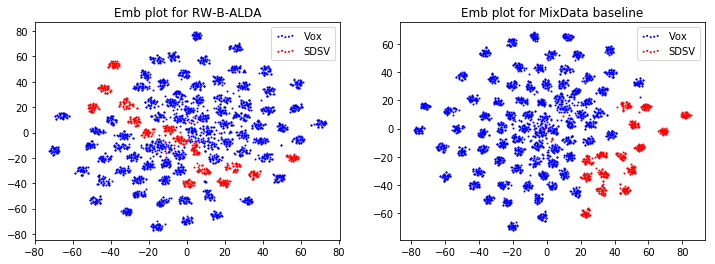

In [38]:
plt.figure(figsize=(12, 4))

out_list = np.zeros([0, 512])
for i in range(75):
    out_list = np.append(out_list, emb_list[i][0:40], axis=0)
out_list_2 = np.zeros([0, 512])
for i in range(15):
    out_list_2 = np.append(out_list_2, emb_list_2[i+1211][0:40], axis=0)
out_label = out_list.shape[0]*[0] +out_list_2.shape[0]*[1]
out_list_f = np.append(out_list, out_list_2, axis=0)
tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
Y = tsne.fit_transform(out_list_f)

plt.subplot(1, 2, 1)
Y1 = Y[0:out_list.shape[0]]
out_label_1 = out_label[0:out_list.shape[0]]
Y2 = Y[out_list.shape[0]:out_list.shape[0]+out_list_2.shape[0]]
out_label_2 = out_label[out_list.shape[0]:out_list.shape[0]+out_list_2.shape[0]]
a = plt.scatter(Y1[:, 0], Y1[:, 1], color='b', s=1)
b = plt.scatter(Y2[:, 0], Y2[:, 1], color='r', s=1)
plt.legend([a, b],['Vox', 'SDSV'], scatterpoints=5)
plt.title('Emb plot for RW-B-ALDA')

out_list = np.zeros([0, 512])
for i in range(75):
    out_list = np.append(out_list, emb_list_ori[i][0:40], axis=0)
out_list_2 = np.zeros([0, 512])
for i in range(15):
    out_list_2 = np.append(out_list_2, emb_list_ori_2[i+1211][0:40], axis=0)
out_label = out_list.shape[0]*[0] +out_list_2.shape[0]*[1]
out_list_f = np.append(out_list, out_list_2, axis=0)
tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
Y = tsne.fit_transform(out_list_f)

plt.subplot(1, 2, 2)
Y1 = Y[0:out_list.shape[0]]
out_label_1 = out_label[0:out_list.shape[0]]
Y2 = Y[out_list.shape[0]:out_list.shape[0]+out_list_2.shape[0]]
out_label_2 = out_label[out_list.shape[0]:out_list.shape[0]+out_list_2.shape[0]]
a = plt.scatter(Y1[:, 0], Y1[:, 1], color='b', s=1)
b = plt.scatter(Y2[:, 0], Y2[:, 1], color='r', s=1)
plt.legend([a, b],['Vox', 'SDSV'], scatterpoints=5)
plt.title('Emb plot for MixData baseline')

plt.savefig('emb_plot1.png', dpi=500, bbox_inches='tight')